<div class="alert alert-info">

#### **LSTM Experiment**

In this notebook we are going to train a simple LSTM classifier on the climbing dataset.

</div>

In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div class="alert alert-info">

#### **1- Preliminary**

We first do a preliminary work to prepare the datasets. In order to know more about this, please read the `experiments/preliminary.ipynb` notebook.

</div>

In [82]:
from experiments.helpers.preliminary import preliminary, FilteringMode, FilteringOperator

In [83]:
# FILTERING_MODE = FilteringMode(0)
# FILTERING_MODE = FilteringMode.NO_PERSONLESS
# FILTERING_MODE = FilteringMode.NO_PERSONLESS | FilteringMode.NO_NOTHING_CLASS
FILTERING_MODE = FilteringMode.NO_PERSONLESS | FilteringMode.NO_NOTHING_CLASS | FilteringMode.NO_STOPWATCH_CLASS
# FILTERING_MODE = FilteringMode.NO_PERSONLESS | FilteringMode.NO_STOPWATCH_CLASS | FilteringMode.NO_NOTHING_CLASS | FilteringMode.NO_MULTI_CLASS

In [84]:
datasets, filtered_datasets, extractors = preliminary(
    filtering_mode=FILTERING_MODE,
    filtering_operator=FilteringOperator.OR,
    ignore_frames_extraction=True
)

[extractor-yolo]:
[extractor-dino]:
[extractor-r3d]:
[extractor-i3d]:
[extractor-clip]:
[extractor-x3d-xs]:
[extractor-x3d-s]:
[extractor-x3d-m]:
[extractor-x3d-l]:
[extractor-s3d-k]:
[extractor-s3d-h]:
[extractor-slowfast]:
[extractor-vivit]:


In [85]:
initial_size = len(datasets[0])
filtered_size = len(filtered_datasets[0])

reduction_percentage = 100 * (initial_size - filtered_size) / initial_size

print(f"[filtering]: {reduction_percentage:.2f}%")

[filtering]: 21.43%


<div class="alert alert-info">

#### **2- Data Adaptation**

The dataset is structured in term of segments, we need to group and order the segments by videos in order to pass the whole video to an LSTM.

</div>

In [86]:
import torch

import numpy as np

from experiments.helpers.full_videos_features_dataset import FullVideosFeaturesDataset

In [87]:
def transform(sample):
    features, annotations, video_id = sample
    
    return torch.stack(features), torch.tensor(np.array(annotations)[0:, 0])

In [88]:
videos_datasets = [
    FullVideosFeaturesDataset(
        dataset=dataset,
        transform=transform,
        verbose=True    
    ) for dataset in filtered_datasets
]

100%|██████████| 3220/3220 [00:00<00:00, 4679.78it/s]


<div class="alert alert-info">

#### **3- Model Definition**

Now we define the globally temporal aware models and their training functions.

</div>

In [89]:
from bouldering_video_segmentation.models import FullVideoLstm

<div class="alert alert-info">

#### **4- Training**

We'll train the different models.

</div>

In [90]:
class WrapperDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.dataset[index])
        else:
            return self.dataset[index]
        
    def __len__(self):
        return len(self.dataset)

In [91]:
def transform(sample):
    features, annotations = sample
    
    annotations = torch.nn.functional.one_hot(annotations, num_classes=5).float()
    
    return features, annotations

In [92]:
def collate_fn(batch):
    features, labels = zip(*batch)
    
    features_padded = torch.nn.utils.rnn.pad_sequence(features, batch_first=True, padding_value=0)
    
    labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-1)
    
    return features_padded, labels_padded

In [ ]:
NUMBER_OF_FOLDS = 5
NUMBER_ANNOTATED_VIDEOS = 22

from bouldering_video_segmentation.utils import LabelEncoderFactory

from experiments.helpers.trainer import Trainer, TrainerVariant
from experiments.helpers.splits_generator import splits_generator
from experiments.helpers.videos_to_indices import videos_to_indices

hidden_size = 128
output_size = 5
num_layers = 1
dropout = 0.0

folds_histories: list[dict] = []

for fold_index, folds in enumerate(splits_generator(dataset_length=NUMBER_ANNOTATED_VIDEOS, k=NUMBER_OF_FOLDS)):
    histories = {}
    
    for dataset, extractor in zip(videos_datasets, extractors):
        training_videos_ids, validation_videos_ids = folds
    
        training_dataset = WrapperDataset(torch.utils.data.Subset(dataset, training_videos_ids), transform=transform)
        validation_dataset = WrapperDataset(torch.utils.data.Subset(dataset, validation_videos_ids), transform=transform)
        
        training_dataloader = torch.utils.data.DataLoader(
            training_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn
        )

        validation_dataloader = torch.utils.data.DataLoader(
            validation_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn
        )
        
        if dataset[0][0].dim() == 3:
            input_size = dataset[0][0].shape[1] * dataset[0][0].shape[2]
        else:
            input_size = dataset[0][0].shape[1]
        
        model = FullVideoLstm(input_size, hidden_size, output_size, num_layers, dropout)    
            
        trainer = Trainer(model=model, variant=TrainerVariant.LSTM)
        
        statistics = trainer.train(training_dataloader, validation_dataloader, title=f"[training-{extractor.get_name()}-{fold_index + 1}/{NUMBER_OF_FOLDS}]")
        
        histories[extractor.get_name()] = statistics
        
    folds_histories.append(histories)

[training-vivit-5/5]: 100%|██████████| 32/32 [00:10<00:00,  3.05epoch/s, training-loss=0.212, training-accuracy=0.927, validation-loss=0.527, validation-accuracy=0.838, best-validation-accuracy=0.82, best-training-accuracy=0.855] 


<div class="alert alert-info">

#### **5- Results**

Below we are going to display the training results for each model.

</div>

In [94]:
from experiments.helpers.training_results_visualization import aggregate_training_results

In [95]:
aggregated_training_results = aggregate_training_results(folds_histories)

models_training_accuracies = aggregated_training_results.models_training_accuracies
models_validation_accuracies = aggregated_training_results.models_validation_accuracies
models_training_losses = aggregated_training_results.models_training_losses
models_validation_losses = aggregated_training_results.models_validation_losses

In [96]:
import matplotlib.pyplot as plt

In [97]:
from experiments.helpers.training_results_visualization import Metric
from experiments.helpers.training_results_visualization import plot_models_performance, plot_models_comparison

<Figure size 1000x500 with 0 Axes>

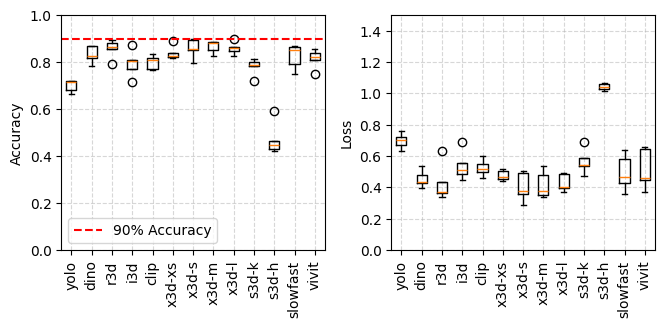

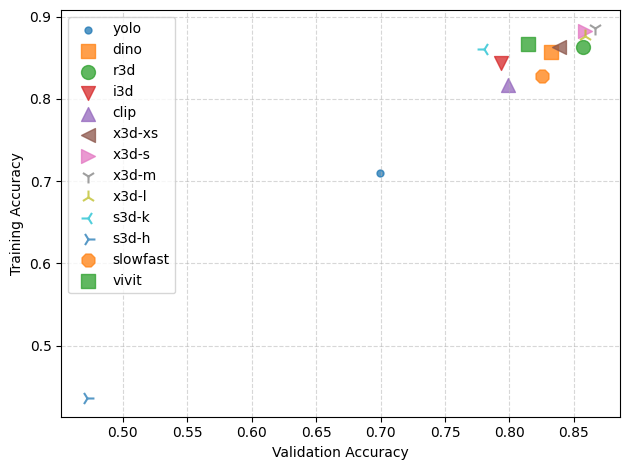

In [112]:
plot_models_performance(
    aggregated_training_results,
    Metric.ALL
)

plt.tight_layout()

plt.show()

plot_models_comparison(
    aggregated_training_results,
    Metric.ACCURACY
)

plt.tight_layout()

plt.show()

In [106]:
plot_models_performance(
    aggregated_training_results,
    Metric.ACCURACY
)

plt.tight_layout()

plt.savefig("../assets/figures/lstm.training-results.boxplot.png")

plt.close()

# --- --- --- ---- ---

plot_models_comparison(
    aggregated_training_results,
    Metric.ACCURACY
)

plt.tight_layout()

plt.savefig("../assets/figures/lstm.training-results.scatter.png")

plt.close()

<THIS IS A SEPARATION LINE> & <THIS IS A SEPARATION LINE> & <THIS IS A SEPARATION LINE> & <THIS IS A SEPARATION LINE> \\


<Figure size 1000x500 with 0 Axes>

In [111]:
from experiments.helpers.training_results_visualization import create_performance_table, write_latex_table

# --- --- --- ---

dataframe = create_performance_table(aggregated_training_results, extractors, latex=True)

dataframe['Model'] = [f"LSTM" for extractor in extractors]
dataframe['\#Parameters'] = [f"{extractor.get_number_of_params()}" for extractor in extractors]

write_latex_table(
    dataframe=dataframe,
    caption="LSTM Models Performance Results.",
    path="../assets/tables/lstm.training-results.tex"
)

# --- --- --- ---

dataframe = create_performance_table(aggregated_training_results, extractors)

markdown_content = "# Pre-Trained Models\n\n"

dataframe['Type'] = [f"`{extractor.get_features_type()}`" for extractor in extractors]
dataframe['Model'] = [f"`LSTM`" for extractor in extractors]
dataframe['Size'] = [f"{extractor.get_number_of_params()}" for extractor in extractors]
dataframe['Download Link'] = [f"[Download Weights](https://github.com/raideno/bouldering-video-segmentation/blob/main/models-weights/lstm.{extractor.get_name()}.pt)" for extractor in extractors]

markdown_table = dataframe.to_markdown(index=False)

markdown_content += markdown_table

with open("../models-weights/lstm.README.md", "w") as file:
    file.write(markdown_content)

<>:8: SyntaxWarning: invalid escape sequence '\#'
<>:8: SyntaxWarning: invalid escape sequence '\#'
/var/folders/hl/2fydtkj52y941xk_cs8nh5200000gn/T/ipykernel_31047/38798940.py:8: SyntaxWarning: invalid escape sequence '\#'
  dataframe['\#Parameters'] = [f"{extractor.get_number_of_params()}" for extractor in extractors]


<div class="alert alert-info">

#### **6- Saving Models Weights**

Below we are going to save the models weights and results.

</div>

In [ ]:
import itertools

from experiments.helpers.training_results_visualization import get_best_performing_fold

fold_index = get_best_performing_fold(aggregated_training_results, Metric.ACCURACY)

folds = next(itertools.islice(splits_generator(dataset_length=NUMBER_ANNOTATED_VIDEOS, k=NUMBER_OF_FOLDS), fold_index, fold_index + 1))

# --- --- --- ---

hidden_size = 128
output_size = 5
num_layers = 1
dropout = 0.0

# --- --- --- ---

training_videos_ids, validation_videos_ids = folds

for dataset, extractor in zip(videos_datasets, extractors):
    training_dataset = WrapperDataset(torch.utils.data.Subset(dataset, training_videos_ids), transform=transform)
    validation_dataset = WrapperDataset(torch.utils.data.Subset(dataset, validation_videos_ids), transform=transform)
    
    training_dataloader = torch.utils.data.DataLoader(
        training_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn
    )

    validation_dataloader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn
    )
    
    if dataset[0][0].dim() == 3:
        input_size = dataset[0][0].shape[1] * dataset[0][0].shape[2]
    else:
        input_size = dataset[0][0].shape[1]
    
    model = FullVideoLstm(input_size, hidden_size, output_size, num_layers, dropout)    
        
    trainer = Trainer(model=model, variant=TrainerVariant.LSTM)
    
    statistics = trainer.train(training_dataloader, validation_dataloader, title=f"[training-{extractor.get_name()}]")
    
    best_model_state_dict = statistics["best_model_state_dict"]
    
    torch.save(best_model_state_dict, f"../models-weights/mlp.{extractor.get_name()}.pt")

[training-yolo/5]:   0%|          | 0/32 [00:00<?, ?epoch/s]


ValueError: multiclass-multioutput is not supported